<a href="https://colab.research.google.com/github/GhoshSwapnil/ML/blob/main/traffic_signal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic signs are important as they help the drivers to follow traffic rules and reduce the number of accidents on road. However, it is often very difficult for a driver to focus on the signs along with the other happenings on the road. In addition to this, traffic sign detection is also very important for the fast growing technology of automated driving and driverless cars.

## In this notebook we use the German Traffic Sign Recognition Benchmark Dataset which has lifelike images of traffic signs which a=have been classified into 43 classes. The train and test sets combined consist of more than 50000 images. We use a Convolutional Neural Network(CNN) for this purpose and achieve a test set accuracy of more than 99%.

In [1]:
import os 
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [2]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 605M/612M [00:03<00:00, 162MB/s]
100% 612M/612M [00:03<00:00, 163MB/s]


In [3]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [5]:
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [6]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [7]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

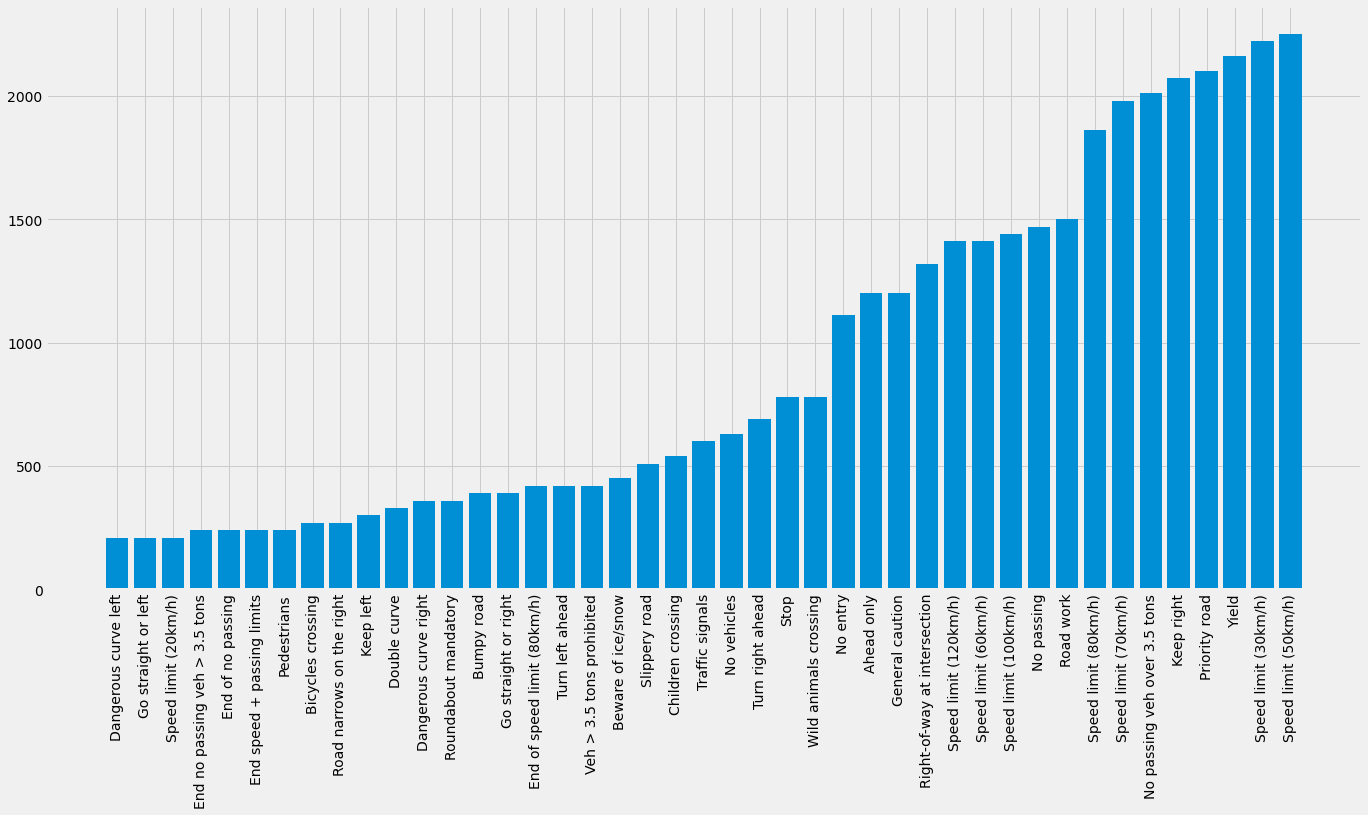

In [8]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

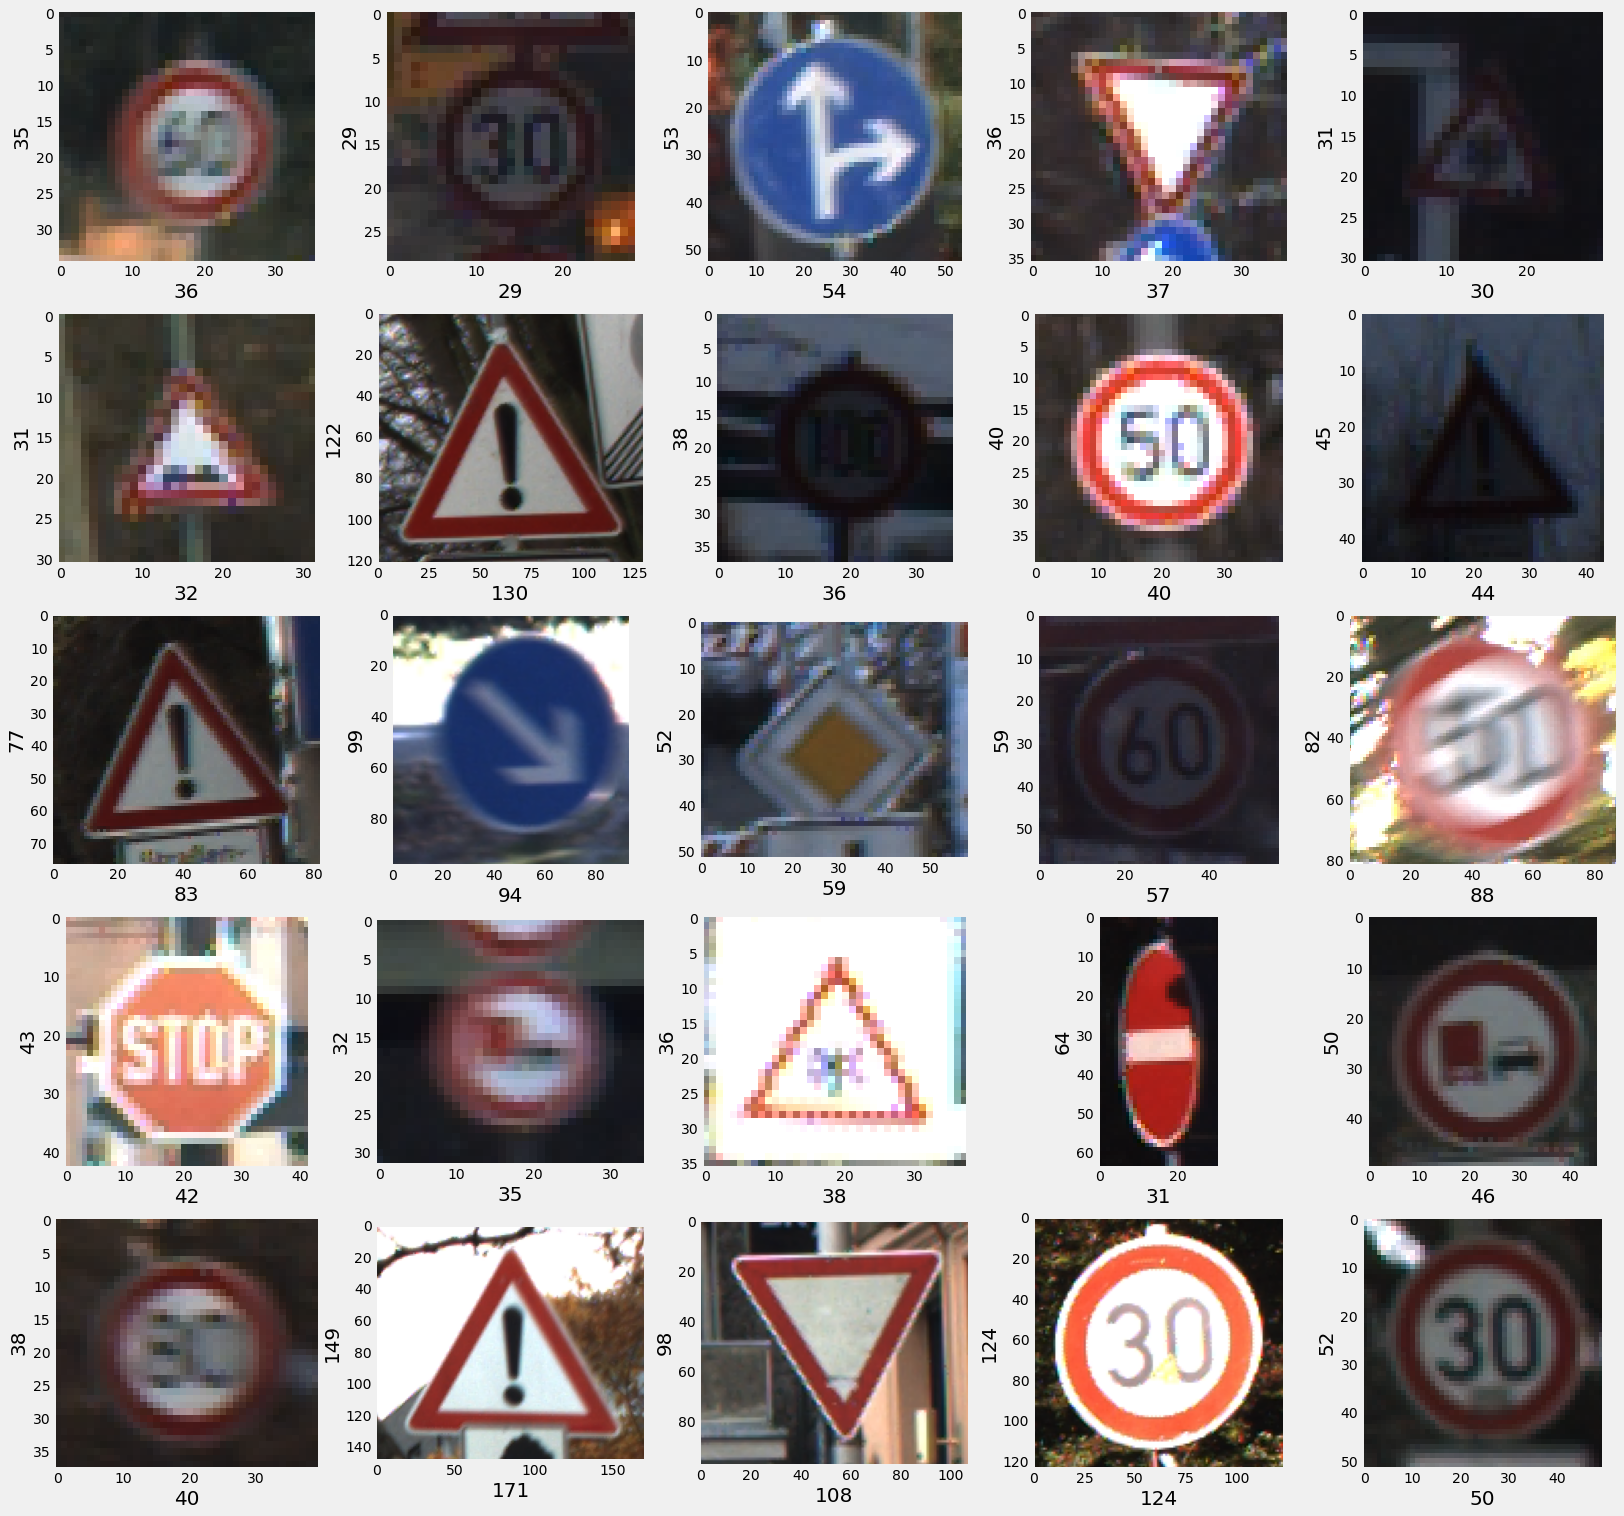

In [9]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [10]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path ='Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [14]:
from tensorflow.keras import models, layers

model = models.Sequential() #Sequential Model

#ConvLayer(64 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(512 filters) + Dropout + ConvLayer(512 filters) + MaxPooling + BatchNormalization
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Flatten
model.add(layers.Flatten())

#2 Dense layers with 4000 hidden units
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))

#Dense layer with 1000 hidden units
model.add(layers.Dense(1000,activation='relu'))

#Softmax layer for output
model.add(layers.Dense(43,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0

In [15]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=0.000066667)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Augmenting the data and training the model

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 31s 26ms/step - loss: 1.7543 - accuracy: 0.4656 - val_loss: 0.6338 - val_accuracy: 0.7647
Epoch 2/30
858/858 [==============================] - 22s 26ms/step - loss: 0.5472 - accuracy: 0.8222 - val_loss: 0.1816 - val_accuracy: 0.9367
Epoch 3/30
858/858 [==============================] - 22s 26ms/step - loss: 0.3091 - accuracy: 0.9041 - val_loss: 0.1426 - val_accuracy: 0.9553
Epoch 4/30
858/858 [==============================] - 22s 25ms/step - loss: 0.2237 - accuracy: 0.9300 - val_loss: 0.0589 - val_accuracy: 0.9829
Epoch 5/30
858/858 [==============================] - 22s 25ms/step - loss: 0.1776 - accuracy: 0.9469 - val_loss: 0.1863 - val_accuracy: 0.9466
Epoch 6/30
858/858 [==============================] - 21s 25ms/step - loss: 0.1630 - accuracy: 0.9553 - val_loss: 0.1013 - val_accuracy: 0.9649
Epoch 7/30
858/858 [==============================] - 22s 25ms/step - loss: 0.1520 - accuracy: 0.9552 - val_loss: 0.0496 - val_accuracy:

In [17]:
model.save("model.h5")

## Evaluating the model

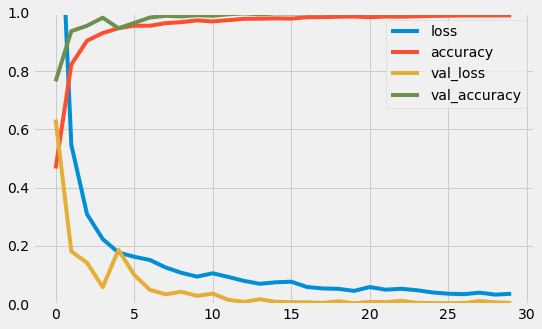

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Visualizing the confusion matrix

In [25]:
Y_test = np.argmax(y_val, axis=1)

Y_pred= model.predict(X_val)

Y_pred= np.argmax(Y_pred, axis=1)

print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_test,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

368/368 [==============================] - 2s 4ms/step
-Acuracy achieved: 99.86%
-Accuracy by model was: 99.05%
-Accuracy by validation was: 99.86%


## Visualizing the confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Y_test, Y_pred)

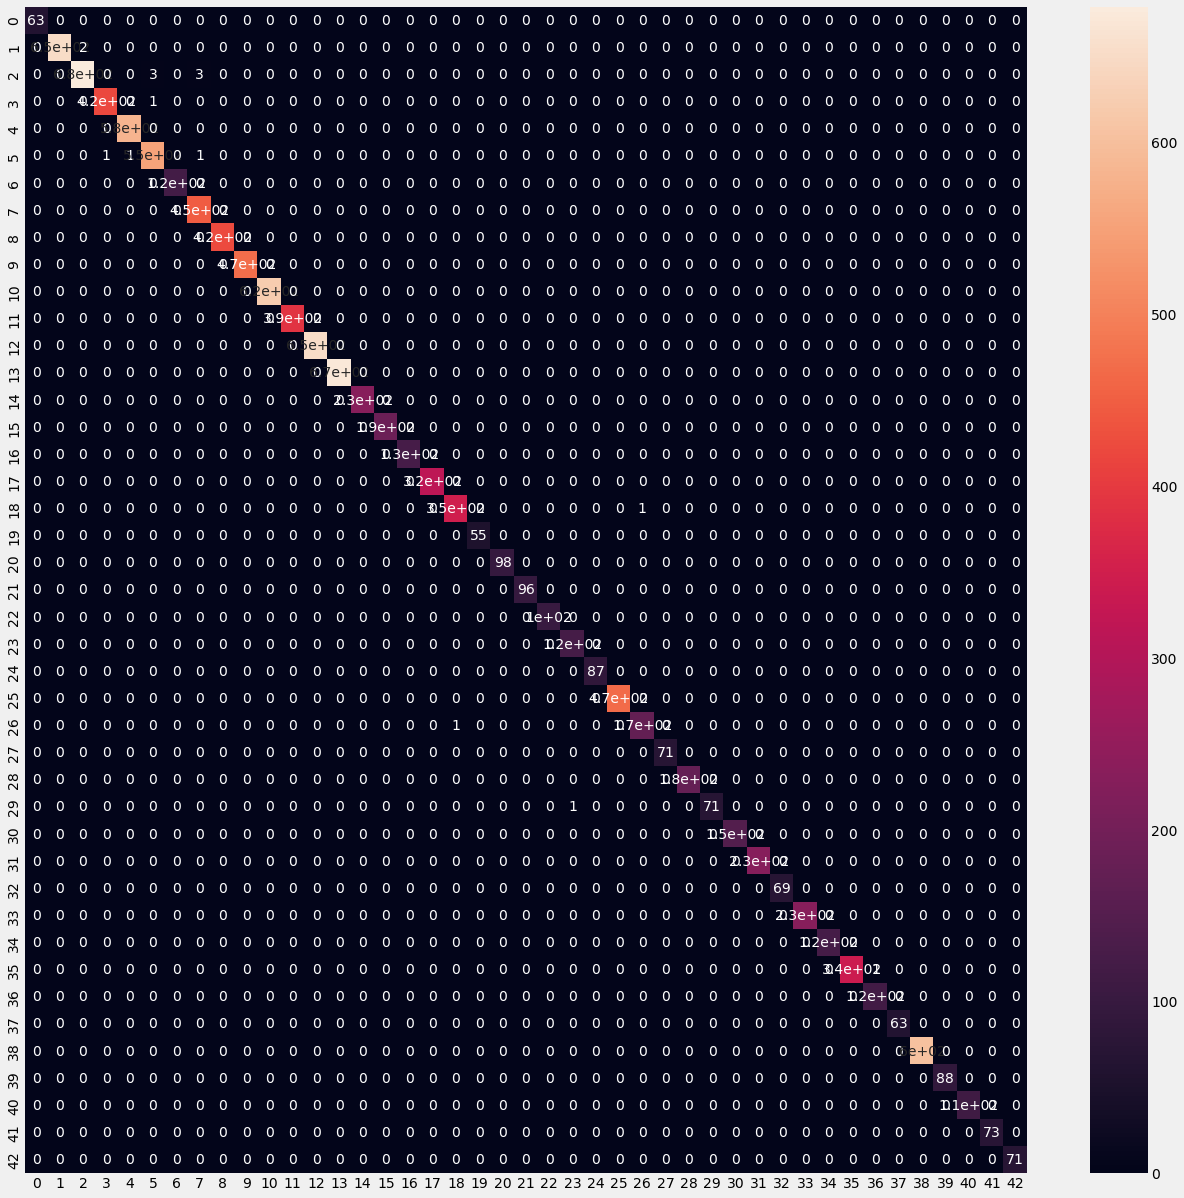

In [31]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [33]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       653
           2       1.00      0.99      0.99       685
           3       1.00      1.00      1.00       421
           4       1.00      1.00      1.00       581
           5       0.99      0.99      0.99       556
           6       1.00      1.00      1.00       121
           7       0.99      1.00      1.00       447
           8       1.00      1.00      1.00       424
           9       1.00      1.00      1.00       470
          10       1.00      1.00      1.00       623
          11       1.00      1.00      1.00       388
          12       1.00      1.00      1.00       651
          13       1.00      1.00      1.00       673
          14       1.00      1.00      1.00       231
          15       1.00      1.00      1.00       187
          16       1.00      1.00      1.00       127
          17       1.00    

## Predictions on Test Data

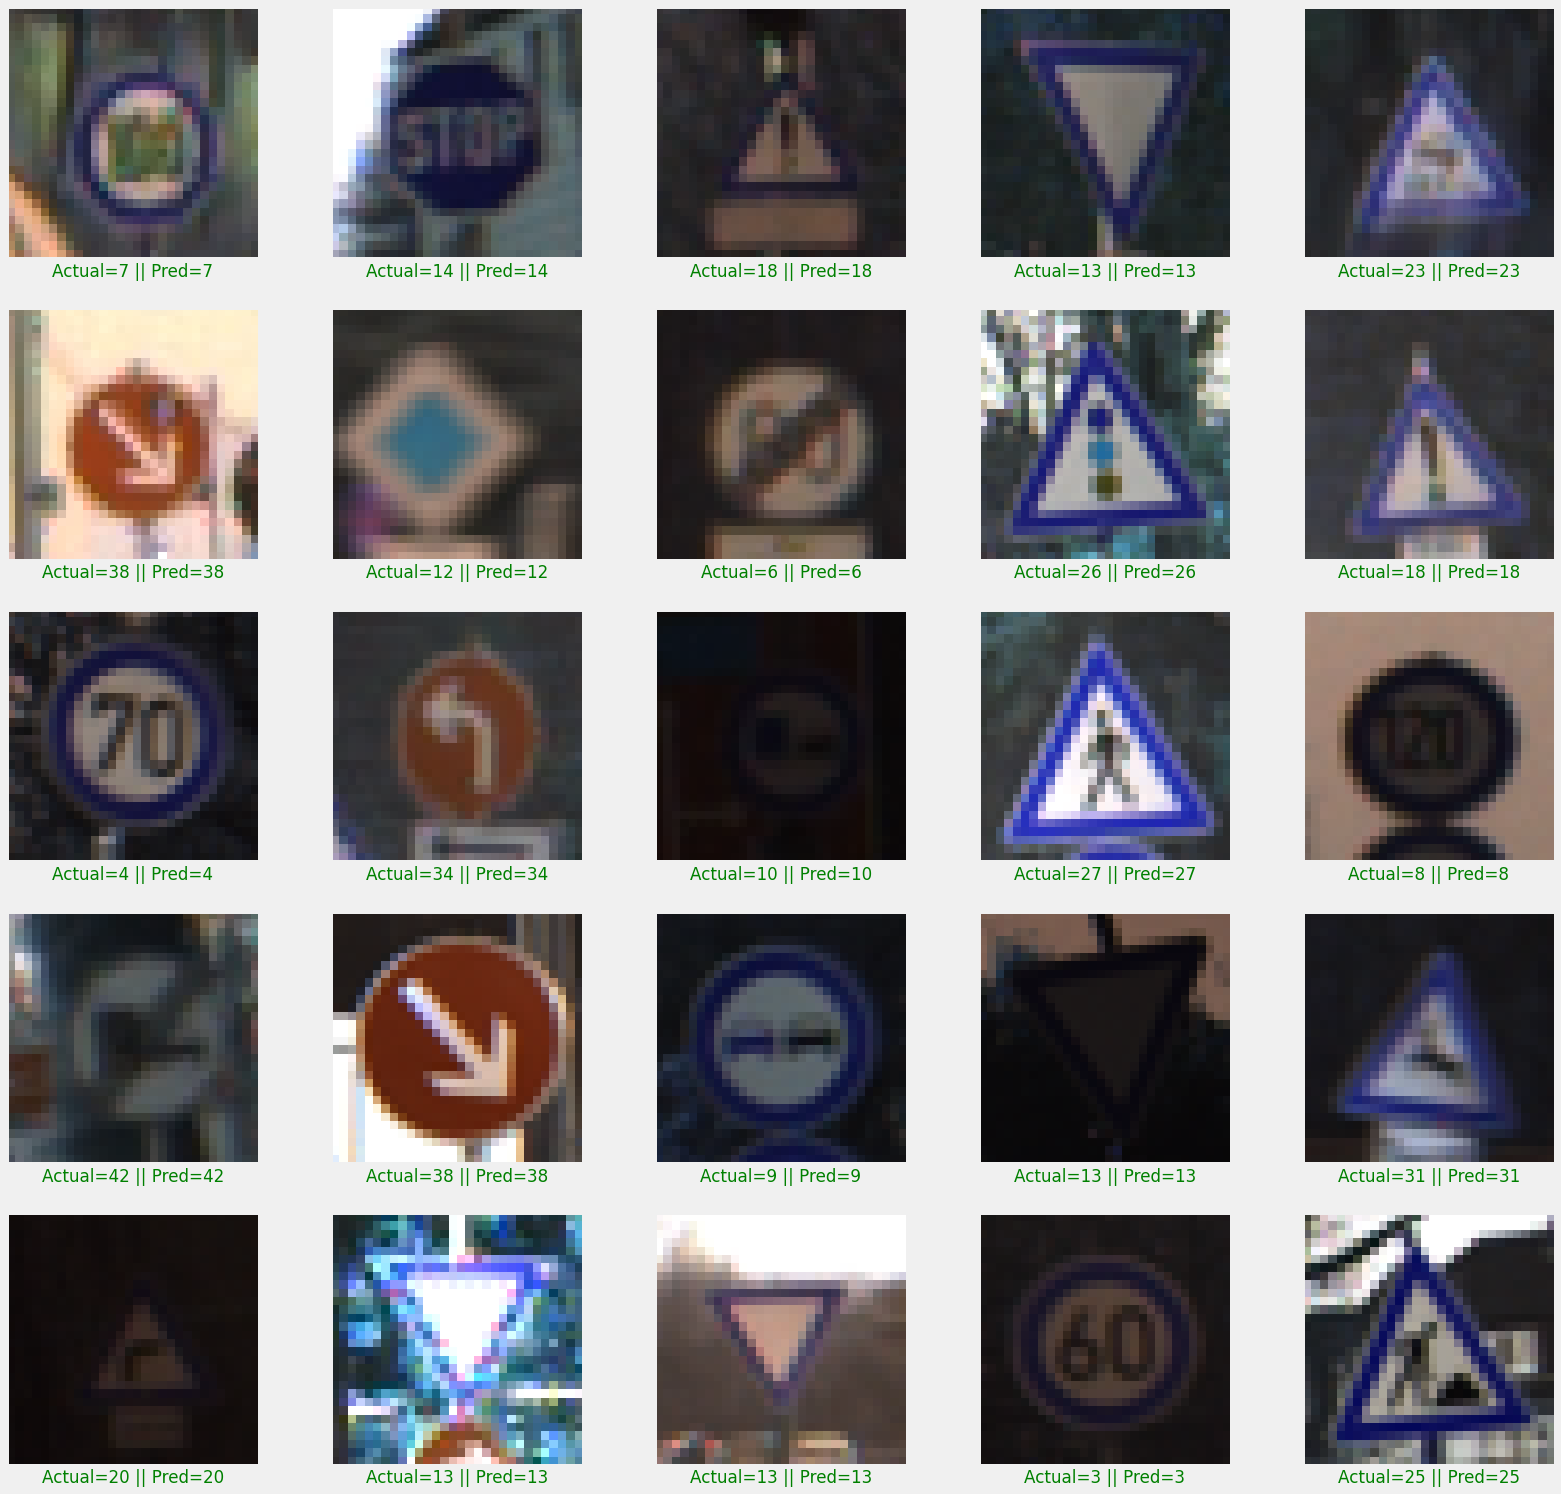

In [34]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = Y_pred[start_index + i]
    actual = Y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_val[start_index + i])
plt.show()